<a href="https://colab.research.google.com/github/YonDraco/learn-deep-learning/blob/main/Second_AutoEncoder_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MNIST Autoencoder

Làm việc với [MNIST dataset](https://www.tensorflow.org/datasets/catalog/mnist). Mã hóa các đầu vào thành hình ảnh có độ phân giải thấp hơn. Sau đó, bộ giải mã sẽ có thể tạo ra đầu vào ban đầu từ biểu diễn nén này.

## Imports

In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass
  
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

## Prepare the Dataset

Tải dữ liệu MNIST từ TFDS vào các tập huấn luyện và thử nghiệm. Đầu tiênlà xác định một chức năng tiền xử lý để chuẩn hóa và làm phẳng hình ảnh. Vì ta sẽ đào tạo một trình mã tự động, điều này sẽ trả về hình ảnh(`image`) vì đầu vào cũng sẽ là mục tiêu hoặc nhãn trong khi đào tạo.


In [2]:
def map_image(image, label):
  '''Bình thường hóa và làm phẳng hình ảnh. Trả về hình ảnh dưới dạng đầu vào và nhãn.'''
  image = tf.cast(image, dtype=tf.float32)
  image = image / 255.0
  image = tf.reshape(image, shape=(784,))

  return image, image

In [3]:
# Load train và bộ kiểm tra từ TFDS

BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 1024

train_dataset = tfds.load('mnist', as_supervised=True, split="train")
train_dataset = train_dataset.map(map_image)
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).repeat()

test_dataset = tfds.load('mnist', as_supervised=True, split="test")
test_dataset = test_dataset.map(map_image)
test_dataset = test_dataset.batch(BATCH_SIZE).repeat()

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


## Build the Model

Xây dựng một bộ mã tự động đơn giản để nhập dữ liệu. Bộ mã hóa sẽ nén đầu vào và tái tạo lại nó trong đầu ra của bộ giải mã.

In [4]:
def simple_autoencoder(inputs):
  '''Tạo bộ mã hóa và giải mã bằng cách sử dụng các lớp dense layer.'''
  encoder = tf.keras.layers.Dense(units=32, activation='relu')(inputs)
  decoder = tf.keras.layers.Dense(units=784, activation='sigmoid')(encoder)
  
  return encoder, decoder

# đặt hình dạng đầu vào
inputs =  tf.keras.layers.Input(shape=(784,))

# nhận đầu ra bộ mã hóa và bộ giải mã
encoder_output, decoder_output = simple_autoencoder(inputs)

# thiết lập bộ mã hóa để hình dung đầu ra của nó sau này
encoder_model = tf.keras.Model(inputs=inputs, outputs=encoder_output)

# cài đặt autoencoder
autoencoder_model = tf.keras.Model(inputs=inputs, outputs=decoder_output)

## Compile the Model

Thiết lập mô hình để đào tạo. Có thể sử dụng phép lai chéo nhị phân để đo độ mất mát giữa các giá trị pixel nằm trong khoảng từ 0 (đen) đến 1 (trắng).

In [5]:
autoencoder_model.compile(
    optimizer=tf.keras.optimizers.Adam(), 
    loss='binary_crossentropy')

## Train the Model

In [6]:
train_steps = 60000 // BATCH_SIZE
simple_auto_history = autoencoder_model.fit(train_dataset, steps_per_epoch=train_steps, epochs=50)

Epoch 1/50
468/468 [==============================] - 8s 11ms/step - loss: 0.3185
Epoch 2/50
468/468 [==============================] - 3s 6ms/step - loss: 0.1520
Epoch 3/50
468/468 [==============================] - 3s 6ms/step - loss: 0.1237
Epoch 4/50
468/468 [==============================] - 3s 6ms/step - loss: 0.1103
Epoch 5/50
468/468 [==============================] - 3s 6ms/step - loss: 0.1030
Epoch 6/50
468/468 [==============================] - 3s 6ms/step - loss: 0.0983
Epoch 7/50
468/468 [==============================] - 3s 6ms/step - loss: 0.0960
Epoch 8/50
468/468 [==============================] - 3s 6ms/step - loss: 0.0947
Epoch 9/50
468/468 [==============================] - 3s 6ms/step - loss: 0.0943
Epoch 10/50
468/468 [==============================] - 3s 6ms/step - loss: 0.0938
Epoch 11/50
468/468 [==============================] - 3s 6ms/step - loss: 0.0937
Epoch 12/50
468/468 [==============================] - 3s 6ms/step - loss: 0.0935
Epoch 13/50
468/468 [===

## Display sample results

Kết quả và vẽ biểu đồ các giá trị được mã hóa và giải mã.

In [7]:
def display_one_row(disp_images, offset, shape=(28, 28)):
  '''Hiển thị kết quả đầu ra mẫu trong một hàng.'''
  for idx, test_image in enumerate(disp_images):
    plt.subplot(3, 10, offset + idx + 1)
    plt.xticks([])
    plt.yticks([])
    test_image = np.reshape(test_image, shape)
    plt.imshow(test_image, cmap='gray')


def display_results(disp_input_images, disp_encoded, disp_predicted, enc_shape=(8,4)):
  '''Hiển thị các giá trị đầu ra đầu vào, được mã hóa và giải mã.'''
  plt.figure(figsize=(15, 5))
  display_one_row(disp_input_images, 0, shape=(28,28,))
  display_one_row(disp_encoded, 10, shape=enc_shape)
  display_one_row(disp_predicted, 20, shape=(28,28,))

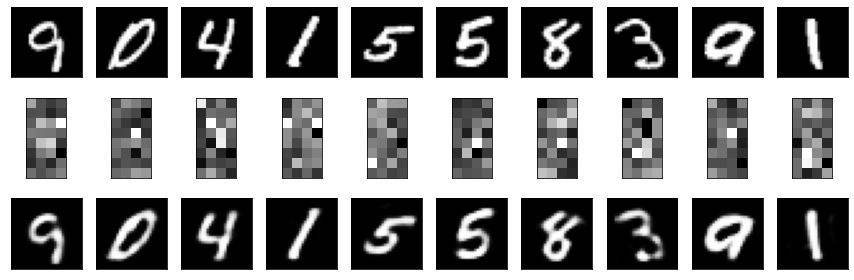

In [8]:
# lấy 1 loạt tập dữ liệu
test_dataset = test_dataset.take(1)

# lấy hình ảnh đầu vào và đưa chúng vào danh sách
output_samples = []
for input_image, image in tfds.as_numpy(test_dataset):
      output_samples = input_image

# chọn 10 số ngẫu nhiên được sử dụng làm chỉ số cho danh sách trên
idxs = np.random.choice(BATCH_SIZE, size=10)

# lấy đầu ra bộ mã hóa
encoded_predicted = encoder_model.predict(test_dataset)

# nhận dự đoán cho batch thử nghiệm
simple_predicted = autoencoder_model.predict(test_dataset)

# hiển thị 10 mẫu, mã hóa và giá trị đã giải mã
display_results(output_samples[idxs], encoded_predicted[idxs], simple_predicted[idxs])